In [1163]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

from pykrx import stock
from pykrx import bond
from datetime import datetime
from tqdm import tqdm
import warnings
warnings.filterwarnings(action='ignore')

https://github.com/sharebook-kr/pykrx \
https://expansion-of-thinking.tistory.com/16

In [1166]:
def get_market_indices(market):
    tickers = stock.get_index_ticker_list(market=market)
    
    sub_cat = {}
    for ticker in tickers:
        index_name = stock.get_index_ticker_name(ticker)
        sub_cat[ticker] = f'{market}:{index_name}'
    sub_cat = dict((v, k) for k, v in sub_cat.items())
    
    indices_df = pd.DataFrame(sub_cat.items(), columns=['market_index_name','code'])
    indices_df[['market','index_name']] = indices_df['market_index_name'].str.split(':', expand=True)
    indices_df = indices_df.drop(columns=['market_index_name'])

    return indices_df

markets_list = ['KOSPI','KOSDAQ','KRX','테마']
# get market indices names and codes
market_indices_all = pd.concat([get_market_indices(market) for market in markets_list], axis=0)
# get market indices listing info
market_listing_info_all = pd.concat([stock.get_index_listing_date(market) for market in markets_list], axis=0)
market_listing_info_all['기준시점'] = market_listing_info_all['기준시점'].str.replace('.', '')
market_listing_info_all['발표시점'] = market_listing_info_all['발표시점'].str.replace('.', '')

# merge all market index summary
market_indices_summary = market_indices_all.merge(
    market_listing_info_all.reset_index().rename(columns={'지수명':'index_name','기준시점':'from_date'}),
    how='left',
    on='index_name'
)

# subset major index and its components
summary_subset_df = market_indices_summary[market_indices_summary.index_name.isin(['코스피 200','코스닥 150'])]
summary_subset_df['index_components'] = summary_subset_df['code'].apply(lambda x: stock.get_index_portfolio_deposit_file(x))
summary_subset_df = summary_subset_df.set_index('code')

# sanity check
assert (summary_subset_df['종목수'] == summary_subset_df.index_components.apply(lambda x: len(x))).sum() == summary_subset_df.shape[0]

In [1167]:
to_date = pd.Timestamp.now().strftime('%Y%m%d')

index_fundamentals_list = []
for code in tqdm(summary_subset_df.index.tolist()):
    index_name = summary_subset_df.loc[code, 'index_name']
    from_date = summary_subset_df.loc[code, 'from_date']
    index_components = summary_subset_df.loc[code, 'index_components']
    print(index_name, from_date, to_date, code)
    index_fundamentals = stock.get_index_fundamental(from_date, to_date, code)
    index_fundamentals['index_name'] = index_name
    index_fundamentals_list.append(index_fundamentals)

# index summary into df
index_fundamentals_df = pd.concat(index_fundamentals_list, axis=0)

  0%|                                                     | 0/2 [00:00<?, ?it/s]

코스피 200 19900103 20250105 1028


 50%|██████████████████████▌                      | 1/2 [01:12<01:12, 72.32s/it]

코스닥 150 20100104 20250105 2203


100%|█████████████████████████████████████████████| 2/2 [01:44<00:00, 52.07s/it]


In [1178]:
def get_two_tailed_prob(z_score_input):
    # 1. Calculate Probability from Z-Score
    # Cumulative distribution function
    probability_from_z = norm.cdf(z_score_input) - norm.cdf(-z_score_input)
    print(f"Probability for Z-score ({z_score_input}): {probability_from_z}")
    
    return probability_from_z

def get_two_tailed_z_score(confidence_level):
    # 2. Calculate Z-Score from Probability for Two-Tailed Test
    # The remaining probability
    alpha = 1 - confidence_level
    # For two-tailed test, divide alpha by 2
    z_score = norm.ppf(1 - alpha / 2) 
    print(f"Z-score for a ({confidence_level*100}%) two-tailed probability: {z_score}")
    
    return z_score

def standardize(ser):
    return (ser[-1] - ser.mean()) / ser.std()

# KOSPI 200

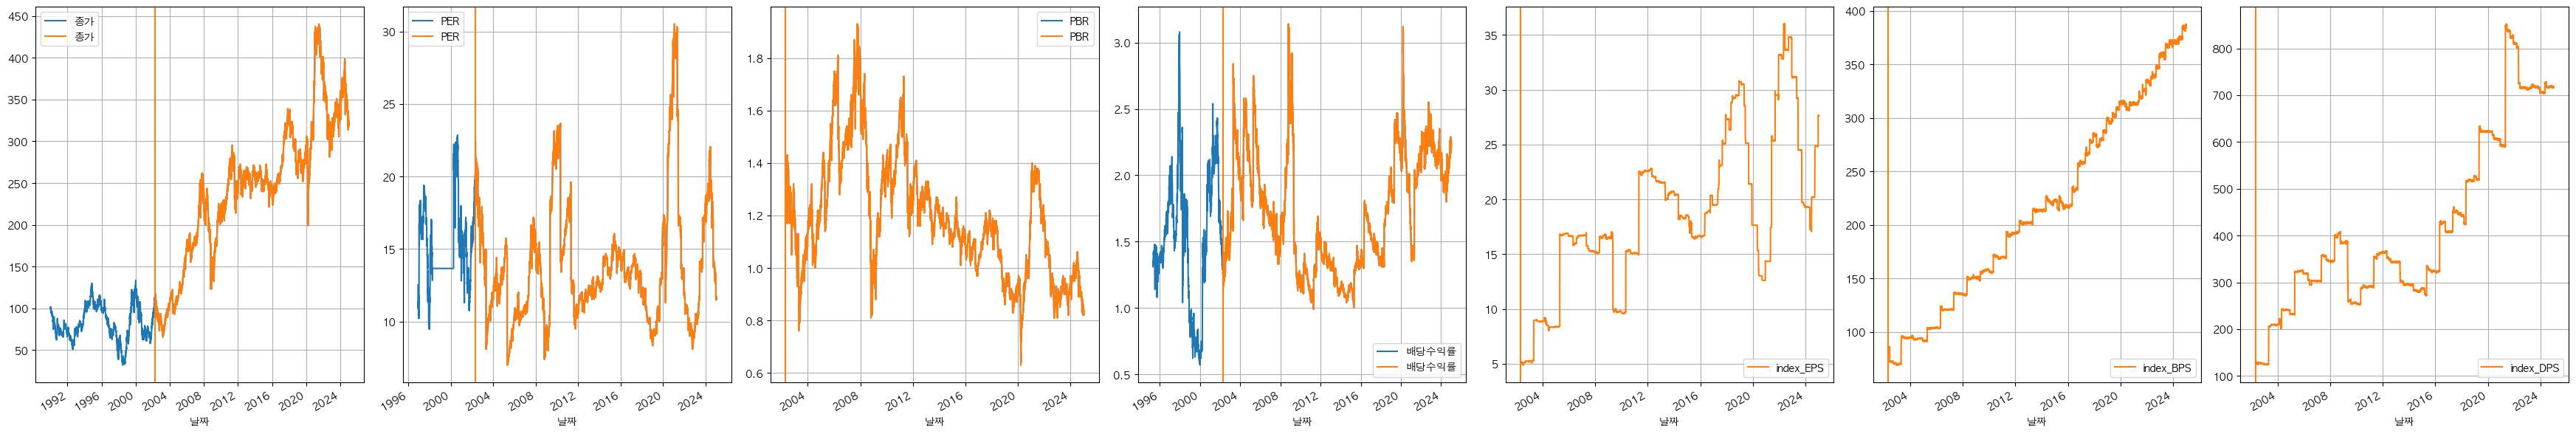

In [1204]:
chosen_index = index_fundamentals_df.query("`index_name` == '코스피 200'")
chosen_index[['PER','PBR','배당수익률']] = chosen_index[['PER','PBR','배당수익률']].replace({0:np.nan, np.inf:np.nan, -np.inf:np.nan}).ffill()
nonzero_start = chosen_index[(~chosen_index[['PER','PBR','배당수익률']].isnull()).sum(axis=1) == 3].index.min()
# filter index from nonzero fundamentals
index_nonzero_start = chosen_index.loc[nonzero_start:]
# remove zero value
index_nonzero_start[['PER','PBR','배당수익률']] = index_nonzero_start[['PER','PBR','배당수익률']].replace({0:np.nan, np.inf:np.nan, -np.inf:np.nan}).ffill()

# extract index fundamentals
index_EPS = (index_nonzero_start['종가'] / index_nonzero_start['PER']).replace({0:np.nan, np.inf:np.nan, -np.inf:np.nan}).ffill()
index_BPS = (index_nonzero_start['종가'] / index_nonzero_start['PBR']).replace({0:np.nan, np.inf:np.nan, -np.inf:np.nan}).ffill()
index_DPS = (index_nonzero_start['종가'] * index_nonzero_start['배당수익률']).replace({0:np.nan, np.inf:np.nan, -np.inf:np.nan}).ffill()

fig,ax = plt.subplots(1,7, figsize=(35,6))
chosen_index['종가'].plot(ax=ax[0])
chosen_index['PER'].plot(ax=ax[1])
chosen_index['PBR'].plot(ax=ax[2])
chosen_index['배당수익률'].plot(ax=ax[3])

index_nonzero_start['종가'].plot(ax=ax[0])
index_nonzero_start['PER'].plot(ax=ax[1])
index_nonzero_start['PBR'].plot(ax=ax[2])
index_nonzero_start['배당수익률'].plot(ax=ax[3])

index_EPS.plot(ax=ax[4], label='index_EPS', c='tab:orange')
index_BPS.plot(ax=ax[5], label='index_BPS', c='tab:orange')
index_DPS.plot(ax=ax[6], label='index_DPS', c='tab:orange')

for i in range(len(ax)):
    ax[i].legend()
    ax[i].grid()
    ax[i].axvline(nonzero_start, label='non_zero_start', c='tab:orange')
plt.tight_layout();

Z-score for a (99.0%) two-tailed probability: 2.5758293035489004
Probability for Z-score (2.5758293035489004): 0.99
subjective
global

global_min:  0.63
global_max:  1.93
latest global_cummin:  0.63
latest global_cummax:  1.93
latest rolling_min:  0.63
latest rolling_max:  1.40



,2025-01-03
valuation_global_min,243.0
valuation_cumulative_min,243.0
valuation_rolling_min,243.0
valuation_norm_max,265.0
valuation_subjective_min,309.0
index_close,324.0
valuation_norm_min,383.0
valuation_subjective_max,463.0
valuation_rolling_max,540.0
valuation_global_max,744.0


날짜
2025-01-03    3.952193
dtype: float64

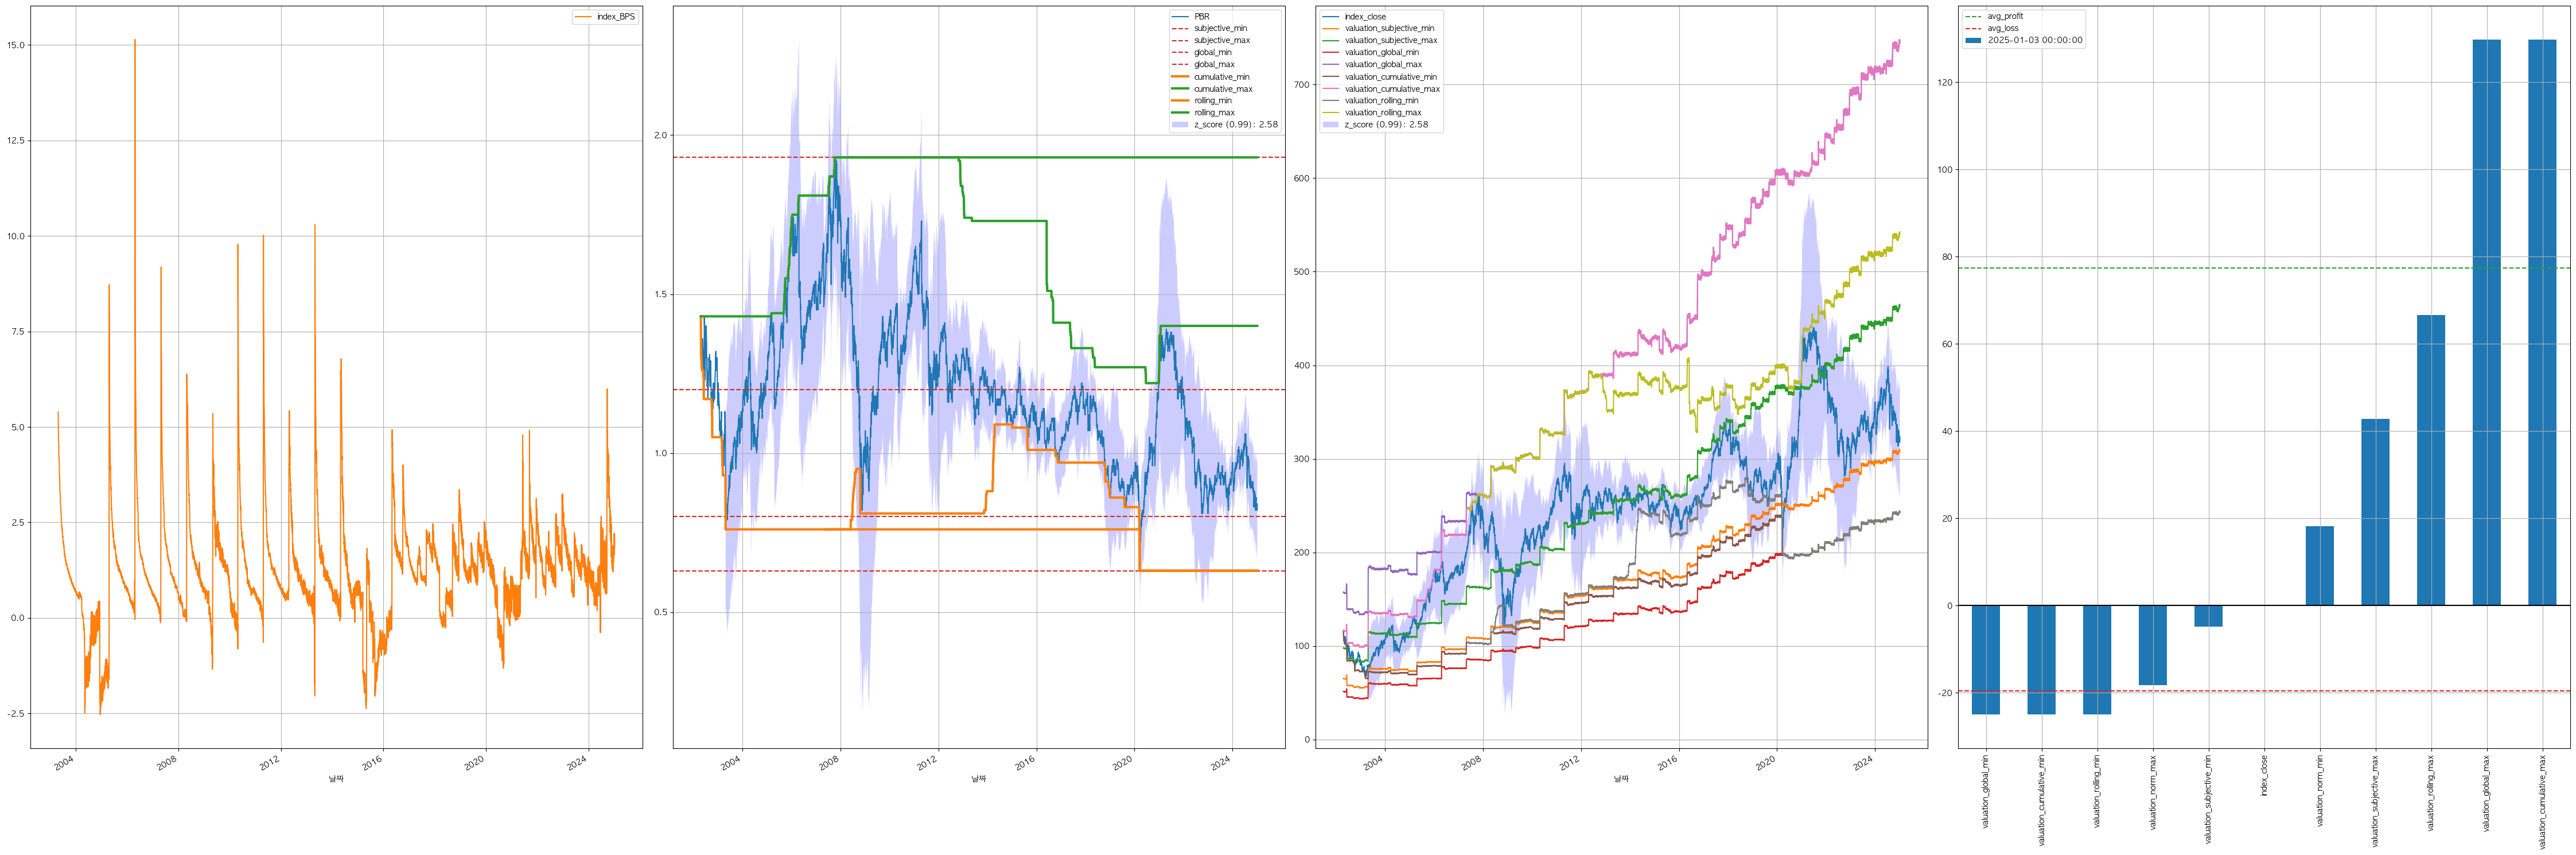

In [1209]:
z_score = get_two_tailed_z_score(confidence_level=0.99)
prob = get_two_tailed_prob(z_score_input=z_score)

fundamental = 'PBR'
subjective_min = 0.8
subjective_max = 1.2
global_min = index_nonzero_start[fundamental].min()
global_max = index_nonzero_start[fundamental].max()
cum_min = index_nonzero_start[fundamental].cummin()
cum_max = index_nonzero_start[fundamental].cummax()
rolling_min = index_nonzero_start[fundamental].rolling(window=252*5).min()
rolling_max = index_nonzero_start[fundamental].rolling(window=252*5).max()

window = 252
index_BPS_norm_upper = index_nonzero_start[fundamental] + index_nonzero_start[fundamental].rolling(window=window).std() * z_score
index_BPS_norm_lower = index_nonzero_start[fundamental] - index_nonzero_start[fundamental].rolling(window=window).std() * z_score

multiple_minmax = {
    'subjective': (subjective_min, subjective_max),
    'global': (global_min, global_max),
    'cumulative': (cum_min, cum_max),
    'rolling': (rolling_min, rolling_max),
    'norm': (index_BPS_norm_upper, index_BPS_norm_lower)
}

# index valuation
index_valuation_df = index_nonzero_start['종가'].rename('index_close').to_frame().copy()
for k,v in multiple_minmax.items():
    index_valuation_df[f'valuation_{k}_min'] = v[0] * index_BPS
    index_valuation_df[f'valuation_{k}_max'] = v[1] * index_BPS

# pnl ratio
pnl_ratio = (index_valuation_df.tail(1).T / index_valuation_df.index_close[-1] - 1) * 100
avg_profit = pnl_ratio[pnl_ratio > 0].dropna().mean()
avg_loss = pnl_ratio[pnl_ratio < 0].dropna().mean()
ratio = avg_profit / abs(avg_loss)

# plot
fig,ax = plt.subplots(1,4, figsize=(45,15))
index_BPS.rolling(window=window).apply(standardize).plot(ax=ax[0], label='index_BPS', c='tab:orange')
index_nonzero_start[fundamental].plot(ax=ax[1])

for k,v in multiple_minmax.items():
    if k == 'norm':
        ax[1].fill_between(x=index_nonzero_start.index, y1=v[0], y2=v[1], 
                           facecolor='b', alpha=0.2, label=f'z_score ({prob:0.2f}): {z_score:0.2f}')
    elif k in ['subjective','global']:
        ax[1].axhline(v[0], c='tab:red', label=f'{k}_min', ls='--')
        ax[1].axhline(v[1], c='tab:red', label=f'{k}_max', ls='--')
        print(k)
    else:
        v[0].plot(ax=ax[1], c='tab:orange', label=f'{k}_min', lw=3)
        v[1].plot(ax=ax[1], c='tab:green', label=f'{k}_max', lw=3)

index_valuation_df.drop(columns=index_valuation_df.filter(regex='.*norm.*').columns).plot(ax=ax[2])
ax[2].fill_between(x=index_valuation_df.index,
                   y1=index_valuation_df[f'valuation_norm_min'], 
                   y2=index_valuation_df[f'valuation_norm_max'], 
                   facecolor='b', alpha=0.2, label=f'z_score ({prob:0.2f}): {z_score:0.2f}')

pnl_ratio.squeeze().sort_values().plot(kind='bar', ax=ax[3])
ax[3].axhline(avg_profit.values, c='tab:green', label=f'avg_profit', ls='--')
ax[3].axhline(avg_loss.values, c='tab:red', label=f'avg_loss', ls='--')
ax[3].axhline(0, c='black')

for i in range(len(ax)):
    ax[i].legend()
    ax[i].grid()
plt.tight_layout();

print(f'''
global_min: {global_min: 0.2f}
global_max: {global_max: 0.2f}
latest global_cummin: {global_cummin[-1]: 0.2f}
latest global_cummax: {global_cummax[-1]: 0.2f}
latest rolling_min: {rolling_min[-1]: 0.2f}
latest rolling_max: {rolling_max[-1]: 0.2f}
''')

display(index_valuation_df.tail(1).T.squeeze().sort_values().to_frame().round())
display(ratio)

# KOSDAQ 150

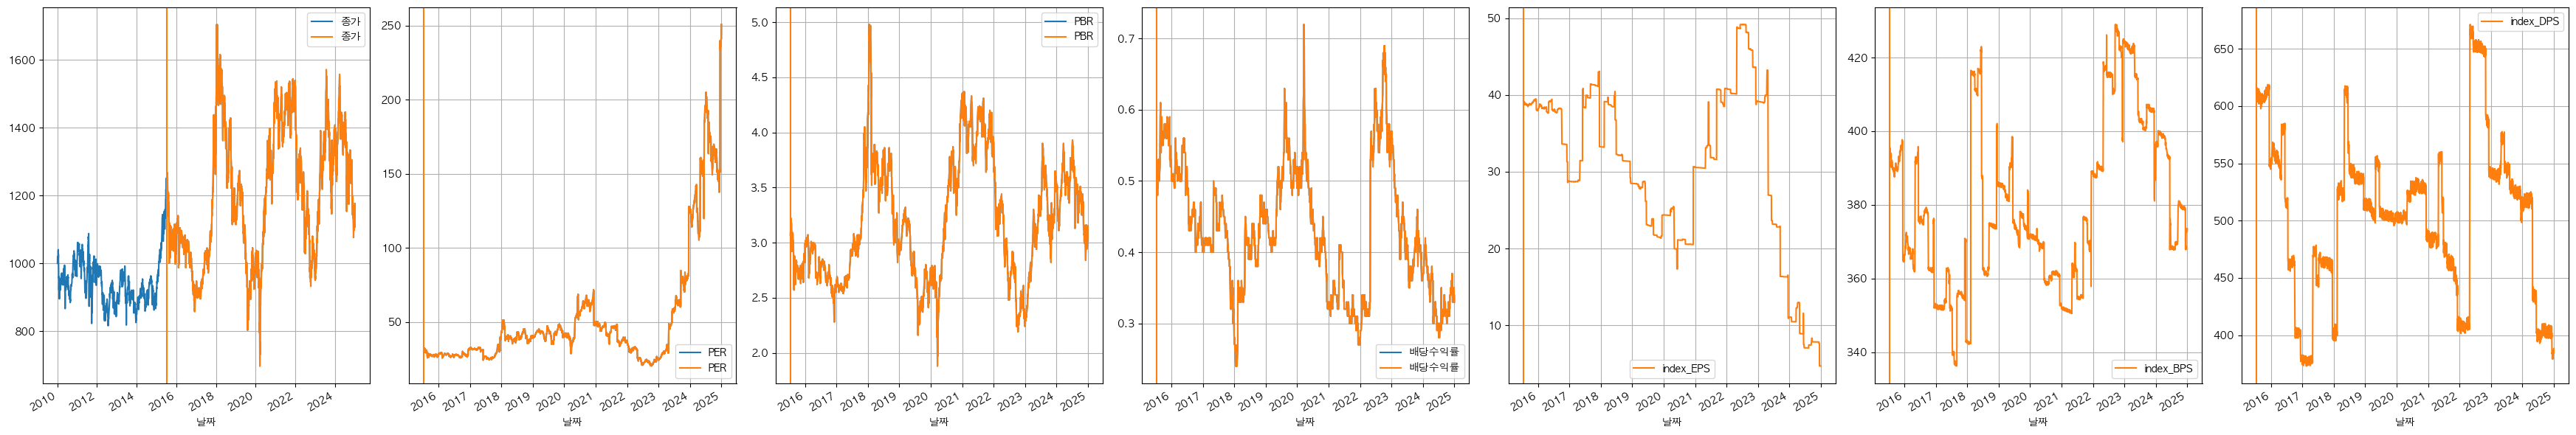

In [1211]:
chosen_index = index_fundamentals_df.query("`index_name` == '코스닥 150'")
chosen_index[['PER','PBR','배당수익률']] = chosen_index[['PER','PBR','배당수익률']].replace({0:np.nan, np.inf:np.nan, -np.inf:np.nan}).ffill()
nonzero_start = chosen_index[(~chosen_index[['PER','PBR','배당수익률']].isnull()).sum(axis=1) == 3].index.min()
# filter index from nonzero fundamentals
index_nonzero_start = chosen_index.loc[nonzero_start:]
# remove zero value
index_nonzero_start[['PER','PBR','배당수익률']] = index_nonzero_start[['PER','PBR','배당수익률']].replace({0:np.nan, np.inf:np.nan, -np.inf:np.nan}).ffill()

# extract index fundamentals
index_EPS = (index_nonzero_start['종가'] / index_nonzero_start['PER']).replace({0:np.nan, np.inf:np.nan, -np.inf:np.nan}).ffill()
index_BPS = (index_nonzero_start['종가'] / index_nonzero_start['PBR']).replace({0:np.nan, np.inf:np.nan, -np.inf:np.nan}).ffill()
index_DPS = (index_nonzero_start['종가'] * index_nonzero_start['배당수익률']).replace({0:np.nan, np.inf:np.nan, -np.inf:np.nan}).ffill()

fig,ax = plt.subplots(1,7, figsize=(35,6))
chosen_index['종가'].plot(ax=ax[0])
chosen_index['PER'].plot(ax=ax[1])
chosen_index['PBR'].plot(ax=ax[2])
chosen_index['배당수익률'].plot(ax=ax[3])

index_nonzero_start['종가'].plot(ax=ax[0])
index_nonzero_start['PER'].plot(ax=ax[1])
index_nonzero_start['PBR'].plot(ax=ax[2])
index_nonzero_start['배당수익률'].plot(ax=ax[3])

index_EPS.plot(ax=ax[4], label='index_EPS', c='tab:orange')
index_BPS.plot(ax=ax[5], label='index_BPS', c='tab:orange')
index_DPS.plot(ax=ax[6], label='index_DPS', c='tab:orange')

for i in range(len(ax)):
    ax[i].legend()
    ax[i].grid()
    ax[i].axvline(nonzero_start, label='non_zero_start', c='tab:orange')
plt.tight_layout();

Z-score for a (99.0%) two-tailed probability: 2.5758293035489004
Probability for Z-score (2.5758293035489004): 0.99
subjective
global

global_min:  1.88
global_max:  4.98
latest global_cummin:  0.63
latest global_cummax:  1.93
latest rolling_min:  1.88
latest rolling_max:  4.37



,2025-01-03
valuation_global_min,702.0
valuation_cumulative_min,702.0
valuation_rolling_min,702.0
valuation_subjective_min,822.0
valuation_norm_max,954.0
index_close,1176.0
valuation_norm_min,1398.0
valuation_subjective_max,1568.0
valuation_rolling_max,1632.0
valuation_global_max,1860.0


날짜
2025-01-03    1.2185
dtype: float64

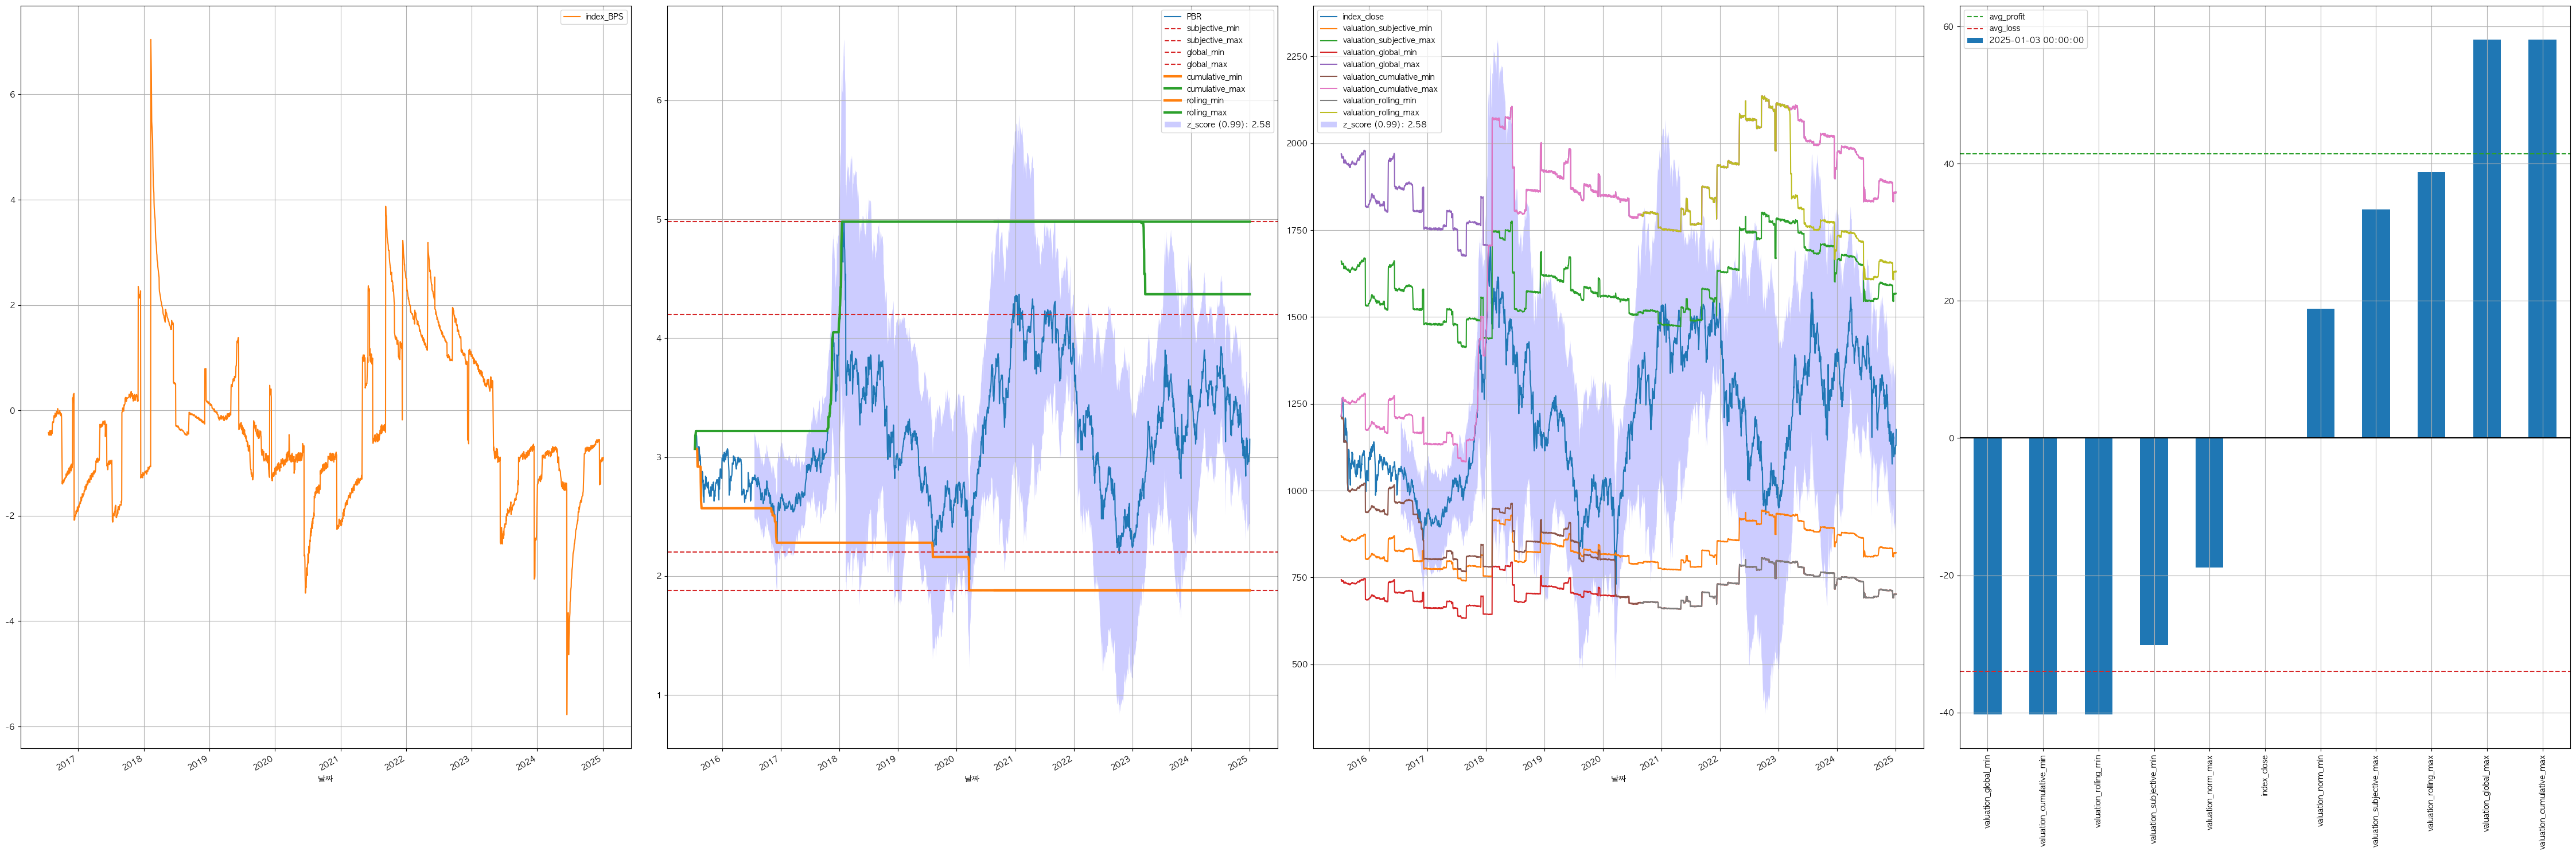

In [1215]:
z_score = get_two_tailed_z_score(confidence_level=0.99)
prob = get_two_tailed_prob(z_score_input=z_score)

fundamental = 'PBR'
subjective_min = 2.2
subjective_max = 4.2
global_min = index_nonzero_start[fundamental].min()
global_max = index_nonzero_start[fundamental].max()
cum_min = index_nonzero_start[fundamental].cummin()
cum_max = index_nonzero_start[fundamental].cummax()
rolling_min = index_nonzero_start[fundamental].rolling(window=252*5).min()
rolling_max = index_nonzero_start[fundamental].rolling(window=252*5).max()

window = 252
index_BPS_norm_upper = index_nonzero_start[fundamental] + index_nonzero_start[fundamental].rolling(window=window).std() * z_score
index_BPS_norm_lower = index_nonzero_start[fundamental] - index_nonzero_start[fundamental].rolling(window=window).std() * z_score

multiple_minmax = {
    'subjective': (subjective_min, subjective_max),
    'global': (global_min, global_max),
    'cumulative': (cum_min, cum_max),
    'rolling': (rolling_min, rolling_max),
    'norm': (index_BPS_norm_upper, index_BPS_norm_lower)
}

# index valuation
index_valuation_df = index_nonzero_start['종가'].rename('index_close').to_frame().copy()
for k,v in multiple_minmax.items():
    index_valuation_df[f'valuation_{k}_min'] = v[0] * index_BPS
    index_valuation_df[f'valuation_{k}_max'] = v[1] * index_BPS

# pnl ratio
pnl_ratio = (index_valuation_df.tail(1).T / index_valuation_df.index_close[-1] - 1) * 100
avg_profit = pnl_ratio[pnl_ratio > 0].dropna().mean()
avg_loss = pnl_ratio[pnl_ratio < 0].dropna().mean()
ratio = avg_profit / abs(avg_loss)

# plot
fig,ax = plt.subplots(1,4, figsize=(45,15))
index_BPS.rolling(window=window).apply(standardize).plot(ax=ax[0], label='index_BPS', c='tab:orange')
index_nonzero_start[fundamental].plot(ax=ax[1])

for k,v in multiple_minmax.items():
    if k == 'norm':
        ax[1].fill_between(x=index_nonzero_start.index, y1=v[0], y2=v[1], 
                           facecolor='b', alpha=0.2, label=f'z_score ({prob:0.2f}): {z_score:0.2f}')
    elif k in ['subjective','global']:
        ax[1].axhline(v[0], c='tab:red', label=f'{k}_min', ls='--')
        ax[1].axhline(v[1], c='tab:red', label=f'{k}_max', ls='--')
        print(k)
    else:
        v[0].plot(ax=ax[1], c='tab:orange', label=f'{k}_min', lw=3)
        v[1].plot(ax=ax[1], c='tab:green', label=f'{k}_max', lw=3)

index_valuation_df.drop(columns=index_valuation_df.filter(regex='.*norm.*').columns).plot(ax=ax[2])
ax[2].fill_between(x=index_valuation_df.index,
                   y1=index_valuation_df[f'valuation_norm_min'], 
                   y2=index_valuation_df[f'valuation_norm_max'], 
                   facecolor='b', alpha=0.2, label=f'z_score ({prob:0.2f}): {z_score:0.2f}')

pnl_ratio.squeeze().sort_values().plot(kind='bar', ax=ax[3])
ax[3].axhline(avg_profit.values, c='tab:green', label=f'avg_profit', ls='--')
ax[3].axhline(avg_loss.values, c='tab:red', label=f'avg_loss', ls='--')
ax[3].axhline(0, c='black')

for i in range(len(ax)):
    ax[i].legend()
    ax[i].grid()
plt.tight_layout();

print(f'''
global_min: {global_min: 0.2f}
global_max: {global_max: 0.2f}
latest global_cummin: {global_cummin[-1]: 0.2f}
latest global_cummax: {global_cummax[-1]: 0.2f}
latest rolling_min: {rolling_min[-1]: 0.2f}
latest rolling_max: {rolling_max[-1]: 0.2f}
''')

display(index_valuation_df.tail(1).T.squeeze().sort_values().to_frame().round())
display(ratio)